In [2]:
import tensorflow as tf

# 定义变量
x = tf.Variable(1.)
total = tf.Variable(0.)

sum_op = total.assign(x + total)
add_op = x.assign(x+1)

for i in range(100):
    total = total + x
    x = x+1
# 输出total的值
print(total.numpy())

5151.0


# 什么是神经网络模型
是放着了人脑中神经网络的特征而构建的模型。在人的大脑中，由众多神经元，由它们相互交织组成的网络就是神经网络。当外界信息输入时，人脑中的神经网络可以通过
神经元之间的相互协作完成信息的传递，并在最后输出结果用于决策。而神经网络模型则是借鉴了其中的信息传递与处理的关系，以用于解决机器学习领域中常见的问题。
由于现实中问题的复杂性，所以神经网络模型一般需要通过大量的样本来训练，以学习得到可以用来推理的能力，从而来解决一些常见的分类或回归问题。


In [5]:
# 训练集和测试集的划分
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  tushare as ts
from sklearn.preprocessing import MinMaxScaler

In [11]:
# 为了将数据统一到一定范围内并加快模型的训练速度，我们需要通过前面导入的MinMaxScaler类来实现数据的归一化处理。通过归一化处理，所有的数据就
#落在了0到1的范围内了。其中，通过MinMaxScaler类的实例化对象对其进行归一化时，需要传入指定格式的数据，即[n_samples, n_features]，表示为n_sample
#行样本，n_features列特征的二维数组，所以首先通过np.reshape()函数将数据的shape转换为指定的格式，然后通过fit_transform()函数对其进行转换，最后
# 再将数据的shape转换为之前的形态



In [13]:
def get_data():
    ts.set_token("5bc162559b5b797dd8e5ec328db5c0f7ee2a2fc0c7f950652a5706a3")
    # 初始化接口,初始化后就可以通过Tushare提供的方法来获取历史数据了
    ts_pro = ts.pro_api()
    # ts_pro._DataApi__http_url = "http://tsapi.majors.ltd:7000"
    df = ts_pro.daily(
        # api=ts_pro,
        ts_code="000001.SZ",
        start_date="20180101",
        end_date="20191201",
        # fields="ts_code, trade_date,open,high,low,close,vol",
    )
    df = df.reindex(index=df.index[::-1])
    # 获取收盘价
    arr = df["close"].values
    # 归一化处理
    arr = np.reshape(arr, newshape=(-1, 1))
    mm = MinMaxScaler()
    arr = mm.fit_transform(arr)
    arr = np.reshape(arr, newshape=(-1))
    # 特征提取及标注标签
    X = []
    Label = []
    window_len = 12
    # 遍历数组
    for i in range(len(arr) - window_len -1):
        X.append(arr[i:i+window_len])
        Label.append(arr[i+window_len])
    X = np.array(X)
    Label = np.array(Label)
    # 划分训练集和测试集
    X_train = X[:300]
    Label_train = Label[:300]
    X_test = X[300:]
    Label_test = Label[300:]
    return X_train, Label_train, X_test, Label_test


In [15]:
# 窗口大小
windows_len = 12
# 隐藏层神经元个数
hidden_units = 64
# 构建模型结构
model_layers = [
    tf.keras.layers.Reshape((windows_len, 1), input_shape=(windows_len,)),
    tf.keras.layers.SimpleRNN(units=hidden_units, return_sequences=False),
    tf.keras.layers.Dense(units=hidden_units, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]

In [16]:
# 构建模型
model = tf.keras.models.Sequential(model_layers)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 12, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



2024-01-31 13:07:34,345 - tensorflow - WARNING - From d:\software\python10\lib\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

Epoch 1/100

2024-01-31 13:07:34,820 - tensorflow - WARNING - From d:\software\python10\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

10/10 [==============================] - 1s 3ms/step - loss: 0.0276
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 3/100
10/10 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.0048
Epoch 7/100
10/10 [==============================] - 0s 2

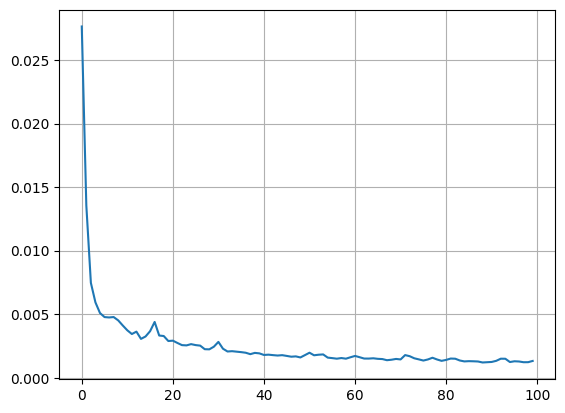

In [17]:
X_train, Label_train, X_test, Label_test = get_data()
# 模型编译
model.compile(optimizer="adam", loss="mean_squared_error")
# 模型训练
history = model.fit(
    X_train,
    Label_train,
    epochs=100
)
# 可视化loss
def plot_loss(loss):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(loss)), loss)
    plt.grid(True)
    plt.show()

# 可视化loss
plot_loss(history.history['loss'])

In [18]:
def plot_result(prediction, true):
    """可视化预测值和真实值"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(prediction)), prediction)
    ax.plot(range(len(true)), true)
    ax.legend(['prediction', 'true'])
    plt.show()

5/5 [==============================] - 0s 2ms/step


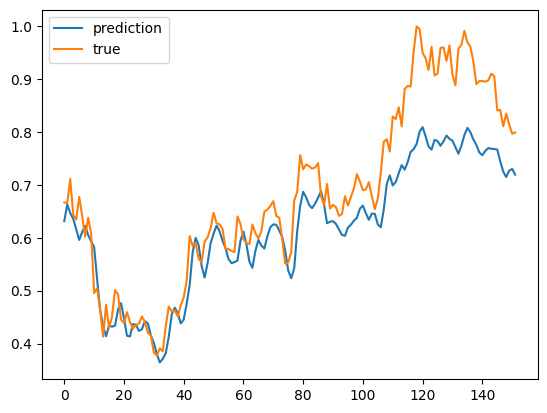

In [19]:
# 模型预测
prediction = model.predict(X_test)
# 可视化预测和真实值
plot_result(prediction, Label_test)